In [33]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models

In [3]:
from sklearn.metrics import roc_auc_score

In [6]:
data_dir = "../data"
glove_dir = os.path.join(data_dir, "glove6B")

MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

## Loading word vectors

In [7]:
print("Loading word vectors")
word2vec = {}
with open(os.path.join(glove_dir, f'glove.6B.{EMBEDDING_DIM}d.txt')) as f:
    # this file is in the format word vec[0] vec[1] vec[2]
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:], dtype='float32')
        word2vec[word] = vec
    print(f'Found {len(word2vec)} word vectors')

Loading word vectors
Found 400000 word vectors


## Loading in comments

In [9]:
train_data = pd.read_csv(os.path.join(data_dir, 'train.csv'))
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [26]:
target_labels = train_data.columns[2:].tolist()
target_labels

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [17]:
if train_data['id'].nunique() == train_data['comment_text'].nunique() == train_data.shape[0]:
    print('No duplicate entries')
else:
    print('Check for duplicates')

No duplicate entries


In [28]:
print(f'The number of observations in training dataset is {train_data.id.nunique()}')
print(f'The number of target labels is {len(target_labels)}')

The number of observations in training dataset is 159571
The number of target labels is 6


### Checking for NA

In [29]:
train_data.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

No NA / Missing values

In [30]:
sentences = train_data['comment_text'].values
targets = train_data[target_labels].values

In [32]:
sentences

array(["Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
       "D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)",
       "Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",
       ...,
       'Spitzer \n\nUmm, theres no actual article for prostitution ring.  - Crunch Captain.',
       'And it looks like it was actually you who put on the speedy to have the first version deleted now that I look at it.',
       '"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of communit

## Plotting sentences length

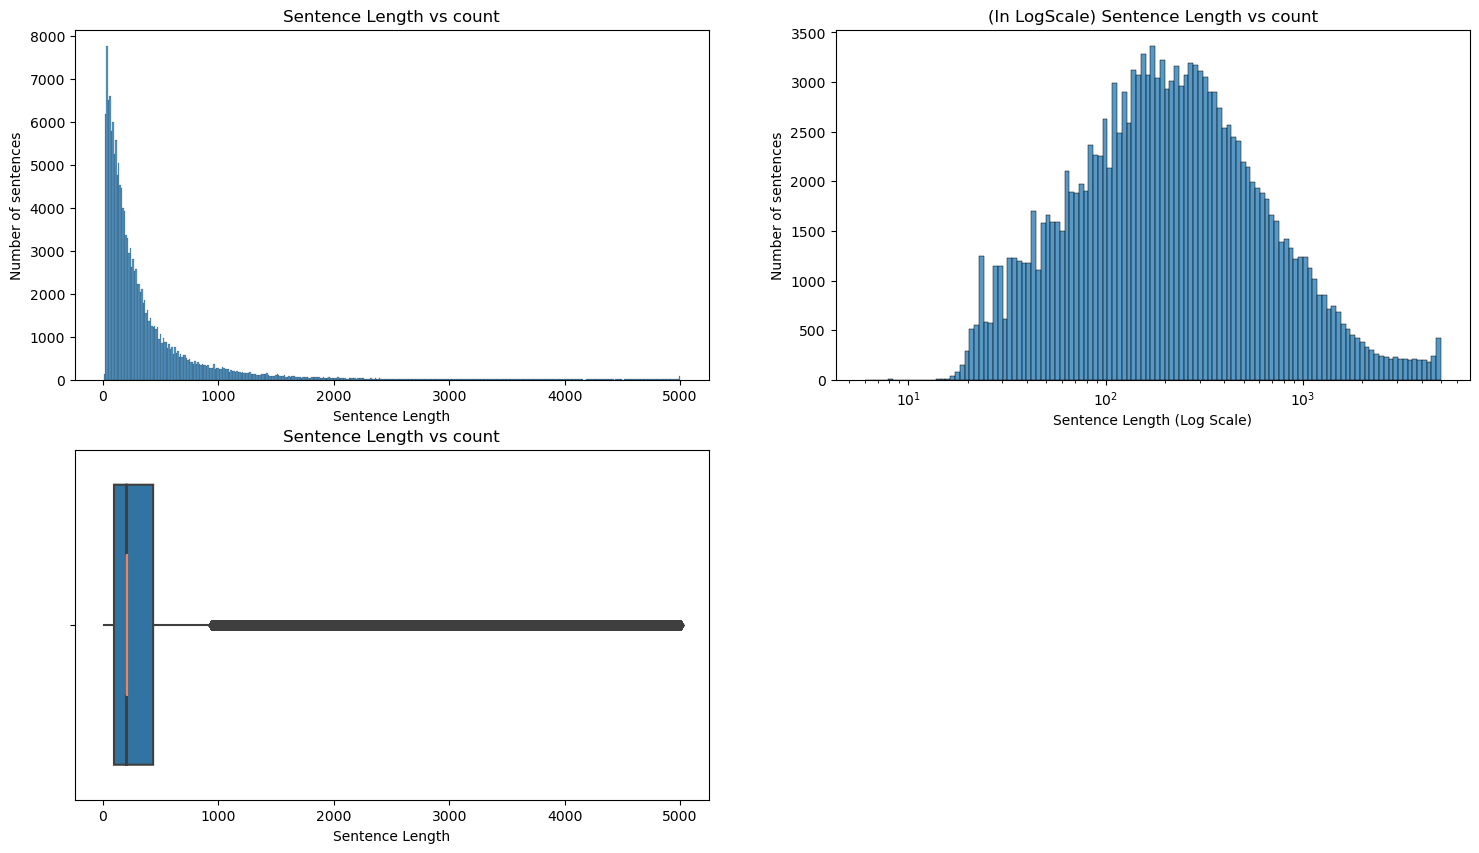

In [66]:
sent_length = np.array([len(s) for s in sentences])
plt.figure(figsize=(18, 10))
plt.subplot(2, 2, 1)
sns.histplot(sent_length)
plt.xlabel('Sentence Length')
plt.ylabel('Number of sentences')
plt.title('Sentence Length vs count')

plt.subplot(2, 2, 2)
sns.histplot(sent_length, log_scale=True)
plt.xlabel('Sentence Length (Log Scale)')
plt.ylabel('Number of sentences')
plt.title('(In LogScale) Sentence Length vs count')

plt.subplot(2, 2, 3)
sns.boxplot(x=sent_length,notch=True, showcaps=False, medianprops={"color": "coral"})
plt.title('Sentence Length vs count')
plt.xlabel('Sentence Length')
plt.show()

In [70]:
print(
    f"The Shortest comment in the comments list has the length of {min(sent_length)}\n"
    f"The Longest comment in the comments list has the length of {max(sent_length)}\n"
    f"The mean length of comments list is {np.mean(sent_length)}\n"
    f"The median length of comments list is {np.median(sent_length)}\n"
)


The Shortest comment in the comments list has the length of 6
The Longest comment in the comments list has the length of 5000
The mean length of comments list is 394.0732213246768
The median length of comments list is 205.0



## Tokenize the sentences

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

https://github.com/keras-team/keras/blob/v2.11.0/keras/preprocessing/text.py

In [72]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

### Checkng how the sentences mapped to sequences of integers

In [87]:
print(
    f"The sentence is \n{sentences[0]}\n\n"
    f"Corresponding sequence is {sequences[0]}\n\n"
    f"Converting sequence back to sentence \n{tokenizer.sequences_to_texts(sequences[:1])[0]}"
)

The sentence is 
Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27

Corresponding sequence is [688, 75, 1, 126, 130, 177, 29, 672, 4511, 12052, 1116, 86, 331, 51, 2278, 11448, 50, 6864, 15, 60, 2756, 148, 7, 2937, 34, 117, 1221, 15190, 2825, 4, 45, 59, 244, 1, 365, 31, 1, 38, 27, 143, 73, 3462, 89, 3085, 4583, 2273, 985]

Converting sequence back to sentence 
explanation why the edits made under my username hardcore metallica fan were reverted they weren't vandalisms just closure on some gas after i voted at new york dolls fac and please don't remove the template from the talk page since i'm retired now 89 205 38 27


In [91]:
word2idx_dict = tokenizer.word_index
print(f'Found {len(word2idx_dict)} unique tokens.')

Found 210337 unique tokens.


In [97]:
[(k, v) for k, v in word2idx_dict.items() if v == 0]

[]

Tokenizer started from 1 to tokenize the words so 0 is reserved for padding

## Pad Sequences to the same length

[https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences)

Padding all sequences to the same length so that we can for a N x T matrix

In [93]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print(f'Shape of data tensor is {data.shape}')

Shape of data tensor is (159571, 100)


## Embedding Matrix

In [100]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx_dict)+1) # adding one because tokenizer starts from 1 to tokenize the words
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, idx in word2idx_dict.items():
    if idx < MAX_VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            # if word not found in word2vec , the corresponding row in embedding matrix will be all zeros
            embedding_matrix[idx] = embedding_vector

In [112]:
print(f'Shape of data tensor is {data.shape}')
print(f'Shape of embedding matrix is {embedding_matrix.shape}')
print(f'Shape of the target is {targets.shape}')

Shape of data tensor is (159571, 100)
Shape of embedding matrix is (20000, 100)
Shape of the target is (159571, 6)


## Building Model

### Embedding Layer

In [113]:
embedding_layer = layers.Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False # to keep embeddings fixed
)

In [114]:
input_ = layers.Input(shape=(MAX_SEQUENCE_LENGTH, ))
x = embedding_layer(input_)

Metal device set to: Apple M1 Pro


2022-12-26 08:38:05.982994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-26 08:38:05.983798: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 1D Convolutional Layer Followed by Maxpooling layer

In [115]:
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)

### Dense layer

In [116]:
x = layers.Dense(128, activation='relu')(x)

### Output layer

In [117]:
output = layers.Dense(len(target_labels), activation='sigmoid')(x)

**Build Model**

In [118]:
model = models.Model(input_, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 100)          2000000   
                                                                 
 conv1d (Conv1D)             (None, 98, 128)           38528     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 10, 128)          0         
 1D)                                                         

In [119]:
model.compile(
    loss='binary_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

### Training Model

In [120]:
history = model.fit(
    data,
    targets,
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS
)

Epoch 1/10


2022-12-26 08:43:41.831443: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-26 08:43:42.258375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


998/998 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9807

2022-12-26 08:44:03.368103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


998/998 [==============================] - 24s 22ms/step - loss: 0.0836 - accuracy: 0.9807 - val_loss: 0.0699 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 20s 20ms/step - loss: 0.0673 - accuracy: 0.9930 - val_loss: 0.0684 - val_accuracy: 0.9940
Epoch 3/10
998/998 [==============================] - 19s 20ms/step - loss: 0.0628 - accuracy: 0.9937 - val_loss: 0.0790 - val_accuracy: 0.9936
Epoch 4/10
998/998 [==============================] - 20s 20ms/step - loss: 0.0597 - accuracy: 0.9938 - val_loss: 0.0692 - val_accuracy: 0.9940
Epoch 5/10
998/998 [==============================] - 20s 20ms/step - loss: 0.0573 - accuracy: 0.9939 - val_loss: 0.0751 - val_accuracy: 0.9941
Epoch 6/10
998/998 [==============================] - 20s 20ms/step - loss: 0.0554 - accuracy: 0.9937 - val_loss: 0.0708 - val_accuracy: 0.9941
Epoch 7/10
998/998 [==============================] - 20s 20ms/step - loss: 0.0535 - accuracy: 0.9938 - val_loss: 0.0908 - val_accuracy: 0.9936
Epo

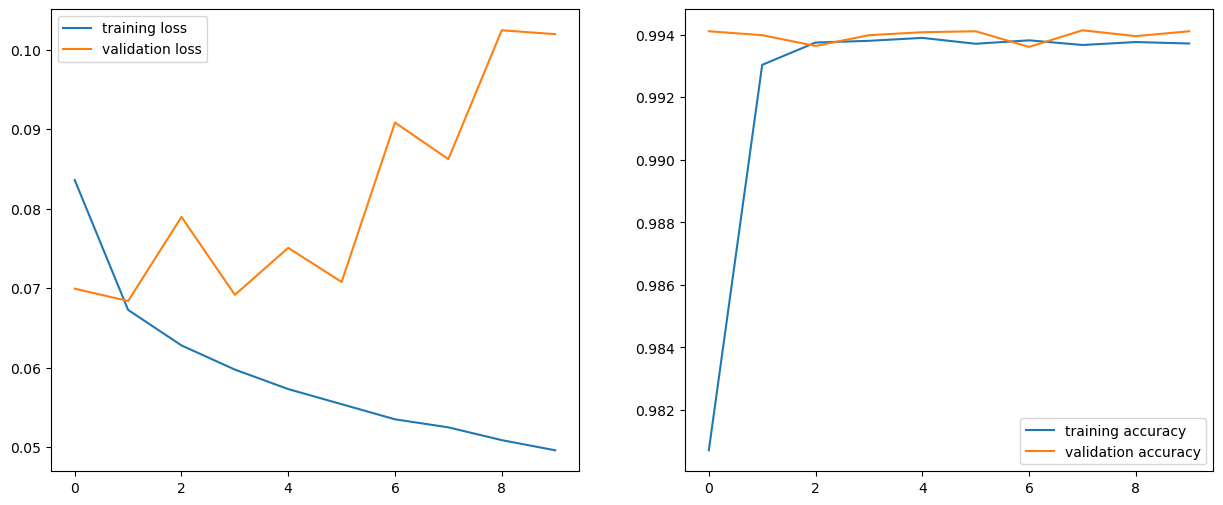

In [138]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [139]:
y_pred = model.predict(data)
aucs = []
for i in range(len(target_labels)):
    auc = roc_auc_score(targets[:, i], y_pred[:, i])
    aucs.append(auc)
print(np.mean(aucs))

2022-12-26 08:57:58.964853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4987/4987 [==============================] - 18s 4ms/step
0.9744007962871768
